<a href="https://colab.research.google.com/github/ChaoyingPei/ECE50024/blob/main/reimplement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F

import PIL.Image as Image

device = 'cpu'

In [2]:
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
test_image = Image.open('bingbing.png').convert("RGB")
test_image_tensor = transforms.ToTensor()(test_image)

# Resize the image tensor to (3, 128, 128)
test_image = F.interpolate(test_image_tensor.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False)
test_image = test_image.squeeze(0)

channels, h, w = test_image.shape
test_image = test_image.unsqueeze(0).to(device)
print(test_image.shape)

torch.Size([1, 3, 256, 256])


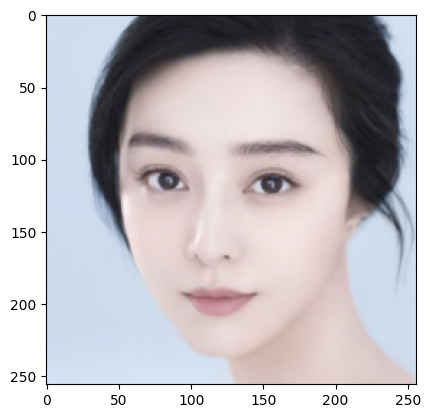

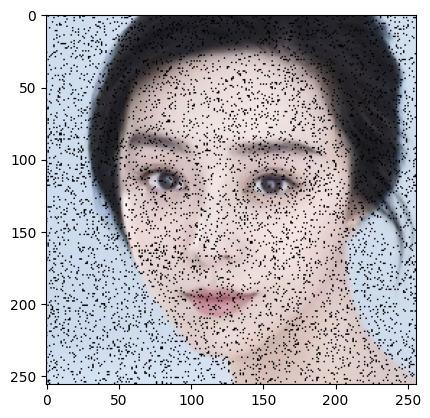

In [3]:
from PIL import Image
import numpy as np

# Randomly choose 6000 indices in the array
indices = np.random.choice(65536, size=6000, replace=False)
# Set the values at those indices to 255 in each channel
def noise(x):
    x_clone = x.clone()
    x_array = x_clone.cpu().numpy()
    for i in range(3):
        x_array[0,i,:,:].flat[indices] = 0
        #print(i)
    return torch.from_numpy(x_array).to(device)
img_noise = noise(test_image)
plt.imshow(test_image.permute(0,2,3,1).squeeze().cpu());
plt.show();
plt.imshow(img_noise.permute(0,2,3,1).squeeze().cpu());
plt.show();

In [4]:
def SVD_denoise(M, rank):
  U, S, V = np.linalg.svd(M)
  S[rank:] = 0
  #print(S)
  U = U[:, :S.size]
  S = np.diag(S)
  V = V[:S.size, :]
  # Reconstruct the image using the modified singular values and vectors
  reconstructed = U @ S @ V
  reconstructed = reconstructed.clip(0,1)
  return reconstructed

In [5]:
def SVD_denoiser(y,rank=50):
  x_clone = y.clone()
  x_array = x_clone.cpu().numpy()
  channel0=x_array[0,0,:,:];
  denoise0=SVD_denoise(channel0, rank);
  channel1=x_array[0,1,:,:];
  denoise1=SVD_denoise(channel1, rank);
  channel2=x_array[0,2,:,:];
  denoise2=SVD_denoise(channel2, rank);
  denoised_channels = np.stack([denoise0, denoise1, denoise2], axis=2)
  denoised_tensor = torch.from_numpy(denoised_channels).permute(2, 0, 1).unsqueeze(0)
  return denoised_tensor

tensor(15.2012)


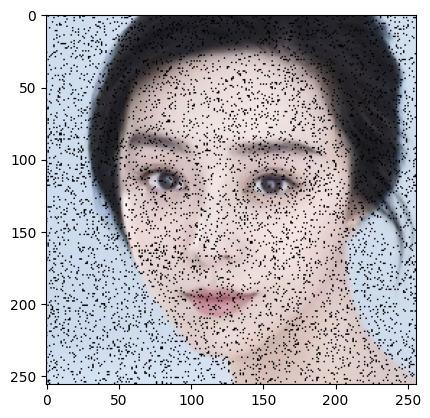

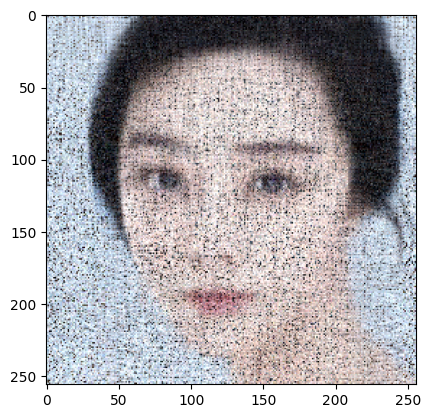

In [36]:
img_noise_clone = img_noise.clone()
denoised_tensor=SVD_denoiser(img_noise_clone,rank=50);
print(SNR(denoised_tensor, test_image))
# Show the denoised image
plt.imshow(img_noise.permute(0,2,3,1).squeeze().cpu());
plt.show();
plt.imshow(denoised_tensor.squeeze().permute(1, 2, 0).cpu())
plt.show()

In [7]:
img_clone = test_image.clone()
img_array = img_clone.cpu().numpy()
channel0=img_array[0,2,:,:];
rank = np.linalg.matrix_rank(channel0)
print(rank)

213


In [8]:
def arg_x(b, x0, rho):
    def A(x):
      return noise(noise(x)) + rho*x
    F = A;
    return conjugate_gradient(F,b,x0);

In [9]:
def conjugate_gradient(F,b,y0):
    y = y0
    r = b-F(y)
    d = r
    for i in range(100):
        z = F(d)
        r_2 = torch.norm(r)**2
        dz=d*z;
        k = r_2/torch.sum(dz)
        y = y + k*d
        r = r - k*z
        epsilon = torch.norm(r)/torch.norm(b);
        if  epsilon < 1e-7:
          break
        d = r + torch.norm(r)**2*d/r_2
    return y;   


In [99]:
def pnp_admm(
        test_img,noised_img, noise,rank=60,
        rho=10**(3), num_iter=50, cg_tol=1e-7
    ):
    delta_tol = 1e-3;
    delta = 1000;
    gamma = 1.03;#adaptive pnp-admm
    #gamma = 1.0;#standard pnp-admm
    eta = 0.6;
    x = torch.zeros_like(noised_img)
    u = torch.zeros_like(noised_img)
    v = torch.zeros_like(noised_img)
    SNR_v = [0] * num_iter
    Delta_v = [0] * num_iter
    print("SVD")
    for i in range(num_iter):
        x_pre=x;
        v_pre=v;
        u_pre=u;
        delta_pre=delta;
        b = noise(noised_img) + rho*(v-u)
        x = arg_x(b, x, rho)
        v = SVD_denoiser(x+u,rank)
        SNR_v[i]=SNR(v, test_img);
        u = u + x - v;
        delta = torch.norm(x-x_pre)+torch.norm(v-v_pre)+torch.norm(u-u_pre);
        Delta_v[i]=delta
        #print(delta)
        if delta <= delta_pre * eta:
          rho=rho;
        else:
          rho = rho*gamma;
        if delta < delta_tol:
          print(i)
          break;
    
    return v,SNR_v,Delta_v,i

In [13]:
def SNR(denoised_img, img):
  noise=torch.mean((denoised_img*255 - img*255) ** 2);
  snr=20 * torch.log10(255.0 / torch.sqrt(noise))
  return snr

In [100]:
denoised_img,SNR_v,Delta_v,iter_conv = pnp_admm(test_image, img_noise, noise, rank=47, num_iter=1000)
SNR_v=SNR_v[:iter_conv];
Delta_v=Delta_v[:iter_conv];
denoised_img = denoised_img.clip(0,1)

SVD
218


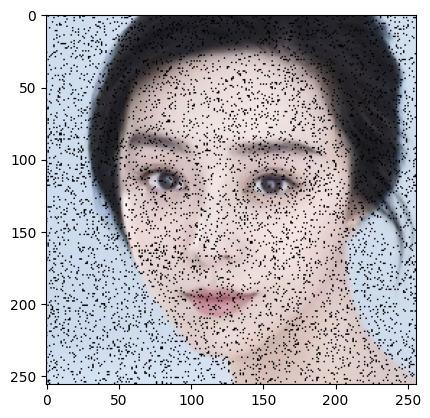

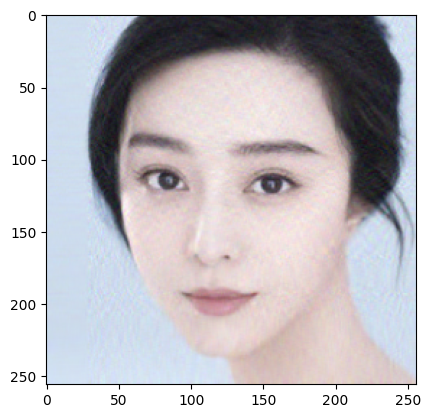

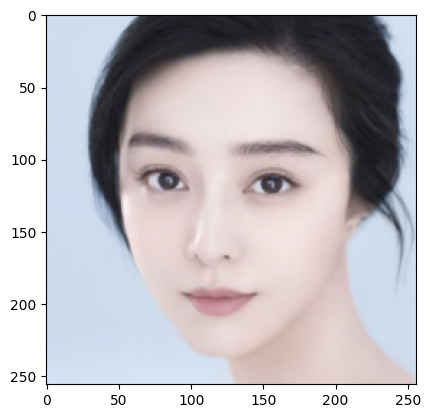

SNR of noised image tensor(12.8134)
SNR of denoised image tensor(35.0587)


In [41]:
plt.imshow(img_noise.permute(0,2,3,1).squeeze().cpu());
plt.show();
plt.imshow(denoised_img.squeeze().permute(1, 2, 0).cpu())
plt.show()
plt.imshow(test_image.squeeze().permute(1, 2, 0).cpu())
plt.show()
print('SNR of noised image',SNR(img_noise, test_image))
print('SNR of denoised image',SNR(denoised_img, test_image))

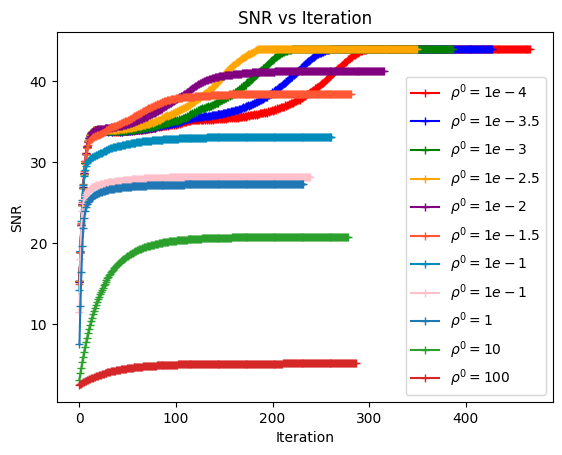

In [103]:
import matplotlib.pyplot as plt

plt.plot(SNR_v4, '-+', color='red', label=r'$\rho^0=1e-4$')
plt.plot(SNR_v35, '-+', color='blue', label=r'$\rho^0=1e-3.5$')
plt.plot(SNR_v3, '-+', color='green', label=r'$\rho^0=1e-3$')
plt.plot(SNR_v25, '-+', color='orange', label=r'$\rho^0=1e-2.5$')
plt.plot(SNR_v2, '-+', color='purple', label=r'$\rho^0=1e-2$')
plt.plot(SNR_v15, '-+', color='#FF5733', label=r'$\rho^0=1e-1.5$')
plt.plot(SNR_v1, '-+', color='#008CBA', label=r'$\rho^0=1e-1$')
plt.plot(SNR_v05, '-+', color='pink', label=r'$\rho^0=1e-1$')
plt.plot(SNR_v0, '-+', color='#1f77b4', label=r'$\rho^0=1$')
plt.plot(SNR_v10, '-+', color='#2ca02c', label=r'$\rho^0=10$')
plt.plot(SNR_v100, '-+', color='#d62728', label=r'$\rho^0=100$')
#plt.plot(SNR_v1000, '-+', color='#9467bd', label=r'$\rho^0=1000$')
plt.xlabel('Iteration')
plt.ylabel('SNR')
plt.title('SNR vs Iteration')
plt.legend()
plt.show()


In [101]:
#SNR_v4=SNR_v# rho=1e-4
#SNR_v35=SNR_v# rho=1e-3.5
#SNR_v3=SNR_v# rho=1e-3
#SNR_v25=SNR_v# rho=1e-2.5
#SNR_v2=SNR_v# rho=1e-2
#SNR_v15=SNR_v# rho=1e-1.5
#SNR_v1=SNR_v# rho=1e-1
#SNR_v05=SNR_v# rho=1e-0.5
#SNR_v0=SNR_v# rho=1e-0
#SNR_v10=SNR_v# rho=10
#SNR_v100=SNR_v# rho=100
SNR_v1000=SNR_v# rho=1000